In [1]:
!pip install geopandas

In [4]:
!pip install python-igraph cairocffi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.7 MB/s eta 0:00:00


In [2]:
!pip install xlrd==1.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: xlrd
    Found existing installation: xlrd 2.0.1
    Uninstalling xlrd-2.0.1:
      Successfully uninstalled xlrd-2.0.1


A este documento se le corrigió la matriz de adyacencias

In [5]:
from numpy import arange,array,dot,asarray,zeros,apply_along_axis,around,sort,shape,savetxt,array_equal,max,argmin,argmax,fill_diagonal,diag,argsort,unique,ones,isnan
from numpy.linalg import eig
from matplotlib.pyplot import plot,figure,title,legend,xlabel,ylabel,grid,axhline,axvline,savefig,imshow,show,scatter,hist,bar,subplots,Normalize,cm,xticks,subplot,tick_params
from math import sqrt,exp
import pandas as pd
from sklearn.cluster import AgglomerativeClustering,KMeans,SpectralClustering
import matplotlib.patches as mpatches
import geopandas
import networkx as nx
import igraph as ig
import json
pd.options.display.max_rows=10

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Funciones para la implementación de los algoritmos y medidas asociadas a un grafo

Conectividad algebraica, matriz laplaciana y clustering espectral

In [7]:
#Construir matriz laplaciana
#W es la matriz de adyacencias o de pesos
def mat_lap(W):
    #Crear matriz diagonal de grados ponderados
    D = diag(W.sum(axis=1))
    #Matriz Laplaciana
    L = D-W
    return L

#Conectividad algebraica
def connect_alg(W,plotting=False):
    #Tamaño de la matriz
    n = len(W)
    #Matriz Laplaciana
    L = mat_lap(W)
    #Eigenvalores y eigenvectores
    eigvals,eigvecs = eig(L)
    #Ordenarlos de forma creciente acorde a los eigenvalores
    eigvecs = eigvecs[:,argsort(eigvals)]
    eigvals = eigvals[argsort(eigvals)]
    connect_value = eigvals[1]
    if plotting == True:
        figure(figsize=(6,4))
        plot(eigvals,linestyle="--",marker="o",markersize=6,linewidth=1.0,color='blue')
        grid()
    return connect_value

#Unnormalized Spectral Clustering
#m es el número de clusters
def spec_clust(W,m):
    #Matriz Laplaciana
    L = mat_lap(W)
    #Eigenvalores y eigenvectores
    eigvals,eigvecs = eig(L)
    #Ordenarlos de forma creciente acorde a los eigenvalores
    eigvecs = eigvecs[:,argsort(eigvals)]
    eigvals = eigvals[argsort(eigvals)]
    #K-means sobre los primeros m-1 eigenvectores asociados a eigenvalores positivos
    kmeans = KMeans(n_clusters=m)
    kmeans.fit(eigvecs[:,1:m])
    clusters = kmeans.labels_
    #Separar las comunidades obtenidas
    com = sep_com(clusters,m)
    return com

#Cambiar la partición resultante por una lista de listas
def sep_com(etiq_kmeans,n_clust):
    com_sep = []
    for k in range(0,n_clust):
        com_sep.append([])
    n = len(etiq_kmeans)
    for i in range(0,n):
        com_act = com_sep[etiq_kmeans[i]]
        com_act.append(i)
    return com_sep

#Imprimir las etiquetas de los nodos que conforman cada comunidad
def imp_names(part,labels):
    n = len(part)
    #Crear tantas listas como comunidades
    names_com = []
    for i in range(0,n):
      names_com.append([])
    for j in range(0,n):
      com_act = part[j]
      name_act = names_com[j]
      k = len(com_act)
      for l in range(0,k):
        name_act.append(labels[com_act[l]])
    for ii in range(0,n):
      print("Comunidad "+str(ii))
      print(names_com[ii])
    return

def sep_labels(labels,particion):
    n = len(particion)
    #Crear tantas listas como comunidades
    names_com = []
    for i in range(0,n):
      names_com.append([])
    for j in range(0,n):
      com_act = particion[j]
      name_act = names_com[j]
      k = len(com_act)
      for l in range(0,k):
        name_act.append(labels[com_act[l]])
    return names_com

Modularidad algebraica, matriz de modularidad y algoritmo de modularidad óptima de Newman

In [8]:
#Función delta de Kronecker
def delta(i,j):
    if i == j:
        out=1
    else:
        out = 0
    return out

#Función que indica si un nodo x pertenece a la comunidad com
def comp(x,com):
    out = 0
    n = len(com)
    for i in range(0,n):
        if x == com[i]:
            out = 1
    return out

#Construir matriz de modularidad
#W es la matriz de adyacencias o de pesos del grafo
def mat_mod(W):
    n = len(W)
    #Sumar los pesos de las aristas que inciden en cada uno de los nodos
    k_v = apply_along_axis(sum,1,W)
    k_v_fila = zeros((1,n))
    k_v_fila[0,:] = k_v
    L = apply_along_axis(sum,1,k_v_fila)/2
    B = zeros((n,n))
    for i in range(0,n):
        for j in range(0,n):
            B[i,j] = W[i,j]-(k_v[i]*k_v[j])/(2*L[0])
    return B

#Modularidad algebraica
def mod_alg(W,plotting=False):
    #Tamaño de la matriz
    n = len(W)
    #Matriz de modularidad
    B = mat_mod(W)
    #Eigenvalores y eigenvectores
    eigvals,eigvecs = eig(B)
    #Ordenarlos de forma creciente acorde a los eigenvalores
    eigvecs = eigvecs[:,argsort(eigvals)]
    eigvals = eigvals[argsort(eigvals)]
    connect_value = eigvals[-1]
    #Eigenvalor líder
    if plotting == True:
        figure(figsize=(6,4))
        plot(eigvals,linestyle="--",marker="o",markersize=6,linewidth=1.0,color='red')
        grid()
    return connect_value

#Construir vector de índices asociado a una comunidad
def vec_ind(n,com):
    vec = zeros((n,1))
    for x in com:
        vec[x,0] = 1
    return vec

#Función para el cálculo de modularidad de una partición
def modularity(W,particion):
    n = len(W)
    #Sumar los pesos de las aristas que inciden en cada uno de los nodos
    k_v = apply_along_axis(sum,1,W)
    k_v_fila = zeros((1,n))
    k_v_fila[0,:] = k_v
    L = apply_along_axis(sum,1,k_v_fila)/2
    B = mat_mod(W)
    #Número de comunidades de la partición
    m = len(particion)
    #Efectuar la suma por cada comunidad
    sum_com = zeros((m))
    for k in range(0,m):
        vec_ind_k = vec_ind(n,particion[k])
        sum_com[k] = dot(dot(vec_ind_k.T,B),vec_ind_k)[0]
    suma = sum(sum_com)
    modularidad = suma/(2*L[0])
    return modularidad

Generalización del algoritmo de modularidad óptima de Newman (GeNA)

In [9]:
def create_com(com_prev,u,threshold=0):
    #The community list corresponds to the vector u
    #All the positive values ​​of u will be assigned to one community and all the negative ones to another
    n = len(com_prev)
    s = zeros((n,1))
    com1,com2 = [],[]
    u11,u22 = [],[]
    #The default threshold value for bipartitioning is zero
    for i in range(0,n):
        if u[i] > threshold:
            com1.append(com_prev[i])
            s[i,0] = 1
            u11.append(u[i])
        #The nodes corresponding to elements of u that are equal to zero are nodes with incident weights equal to zero, so they are discarded
        elif u[i] < threshold:
            com2.append(com_prev[i])
            s[i,0] = -1
            u22.append(u[i])
    return u11,u22,s,com1,com2

def bipartition(B,com):
    n_g = len(com)
    #Build the matrix corresponding to the community that will be split
    B_g = zeros((n_g,n_g))
    cf = 0
    for i in com:
        cc = 0
        for j in com:
            if i == j:
                sum_row = 0
                for k in com:
                    sum_row += B[i,k]
            B_g[cf,cc] = B[i,j]-delta(i,j)*sum_row
            cc += 1
        cf += 1
    #Obtain the eigenvalue and the leading eigenvector
    eigenval,eigenvec = eig(B_g)
    eigenvec = eigenvec[:,argsort(eigenval)]
    eigenval = eigenval[argsort(eigenval)]
    beta1 = eigenval[-1]
    u1 = eigenvec[:,-1]
    u11,u22,s,com1,com2 = create_com(com,u1)
    #It remains to divide the increment by 4m
    inc_mod = dot(dot(s.T,B_g),s)
    return beta1,u11,u22,inc_mod,com1,com2

#A is the adjacency or weight matrix
def GeNA(A):
    n = len(A)
    #Sum the weights of edges that affect each of the nodes
    weight_inc = apply_along_axis(sum,1,A)
    weight_row = zeros((1,n))
    weight_row[0,:] = weight_inc
    m = apply_along_axis(sum,1,weight_row)/2
    B = mat_mod(A)
    #When applying the eig function, the result is a list in which the first element is the array with the eigenvalues
    #The second element is the matrix whose columns are the normalized eigenvectors
    #Get the eigenvalue and the leading eigenvector
    eigenval,eigenvec = eig(B)
    eigenvec = eigenvec[:,argsort(eigenval)]
    eigenval = eigenval[argsort(eigenval)]
    beta1 = eigenval[-1]
    u1 = eigenvec[:,-1]
    #Lists to store the list of the final partition and the final leading eigenvectors
    com_fin,u_fin = [],[]
    #Create list of labels of the nodes that make up the graph
    com = list(range(0,n))
    #Determine if the obtained partition is trivial
    if beta1 <= 0.000001:
        com_fin.append(com)
        u_fin.append(u1)
    else:
        #Create communities according to the sign
        u11,u22,s,com1,com2 = create_com(com,u1)
        com_res,com_res_act = [com1,com2],[com1,com2]
        #List of eigenvectors u that contains the belonging level of each node to its respective community
        u_res,u_act = [u11,u22],[u11,u22]
        n_com = len(com_res)
        while(n_com != 0):
            for j in range(0,n_com):
                beta1,u11,u22,inc_mod,com11,com22 = bipartition(B,com_res[j])
                #Stop dividing the community when the leading eigenvalue is zero or very close to zero
                #A leading eigenvalue close to zero can produce trivial bipartitions
                if beta1 <= 0.000001:
                    com_fin.append(com_res[j])
                    u_fin.append(u_res[j])
                elif len(com11) <= 1 or len(com22) <= 1:
                    #In case a trivial partition has been leaked, the empty community will not be included
                    if len(com11) > 0:
                        com_fin.append(com11)
                        u_fin.append(u11)
                    if len(com22)>0:
                        com_fin.append(com22)
                        u_fin.append(u22)
                else:
                    com_res_act.append(com11)
                    com_res_act.append(com22)
                    u_act.append(u11)
                    u_act.append(u22)
                com_res_act.remove(com_res[j])
                u_act.remove(u_res[j])
            com_res = com_res_act.copy()
            u_res = u_act.copy()
            n_com = len(com_res)
    return u_fin,com_fin

#Obtain level of membership of each node to its community in the original partition
def level_membership_GeNA(u):
    n = len(u)
    belong = []
    for i in range(0,n):
        belong.append([])
        sum_act = sum(u[i])
        for x in u[i]:
            belong_act = belong[i]
            belong_act.append(x/sum_act)
    return belong

#Funciones para el manejo de grafos

In [10]:
#Transformar matriz de adyacencias simétrica a lista de aristas
def trans_ady_sim(A):
    n = len(A)
    list_edges = []
    #Obtener aristas no repetidas y de acuerdo al orden lexicográfico
    for i in range(0,n):
        for j in range(i+1,n):
            if A[i,j] != 0:
                list_edges.append((i,j))
    return list_edges

list_colors=['blue','red','darkorange','gold','magenta','green','hotpink','royalblue','purple','yellow','cyan','navy','brown','olive','lime','silver',
             'gray','crimson','salmon','lawngreen','darkred','crimson','lightgreen','tan','indigo','violet','senna','black','orange','chocolate',
             'steelblue','greenyellow','peru']

def vertex_com(part,num_nodes):
    #Número de comunidades
    n = len(part)
    #Arreglo con la comunidad a la que pertenece cada nodo
    out = zeros((num_nodes))
    for i in range(0,n):
        com_act = part[i]
        len_act = len(com_act)
        for j in range(0,len_act):
            out[com_act[j]] = i
    return out

def list_vertex_color(part,num_nodes):
    num_com = vertex_com(part,num_nodes)
    list_v_color = []
    for i in range(0,num_nodes):
        list_v_color.append(list_colors[int(num_com[i])])
    return list_v_color

#Generar lista de pesos correspondiente a la lista de aristas
def W_list(list_edges,W,num_dig=3):
    #Lista de los pesos
    W_list0 = []
    #Número de aristas
    m = len(list_edges)
    for i in range(0,m):
        edge_act = list_edges[i]
        W_act = round(W[edge_act[0],edge_act[1]],num_dig)
        W_list0.append(W_act)
    return W_list0

#Construir matriz de pesos a partir de las listas de aristas y de pesos
def construct_W(list_edges,list_W,n_W):
    W = zeros((n_W,n_W))
    #Número de aristas
    n_edges = len(list_edges)
    for i in range(0,n_edges):
        edge_act = list_edges[i]
        W[edge_act[0],edge_act[1]] = list_W[i]
    W_out = W+W.T
    return W_out

#Primeros ejemplos con grafos simples

Grafo disconexo con 4 componentes

La conectividad algebraica de este grafo es:
-1.1102230246251565e-16
La modularidad algebraica de este grafo es:
(3.0000000000000004+0j)



/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


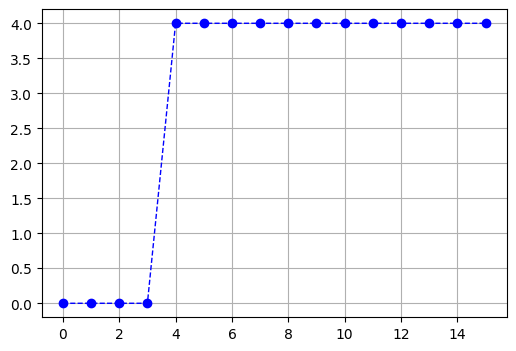

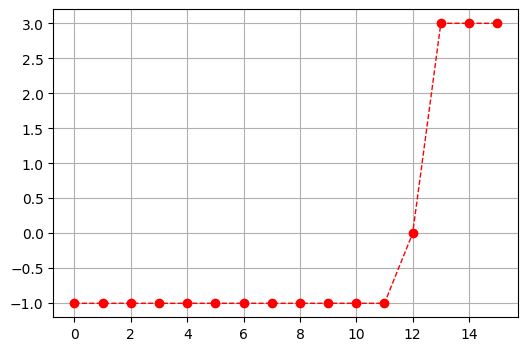

In [11]:
A_disc = array([[0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0],
                [0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0],
                [0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0],
                [0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0],
                [0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0],
                [0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0],
                [0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0]])

conec_alg_A_disc = connect_alg(A_disc,plotting=True)
print("La conectividad algebraica de este grafo es:")
print(conec_alg_A_disc)

mod_alg_A_disc = mod_alg(A_disc,plotting=True)
print("La modularidad algebraica de este grafo es:")
print(mod_alg_A_disc)
print()

Aplicar clustering espectral

[[12, 13, 14, 15], [0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11]]


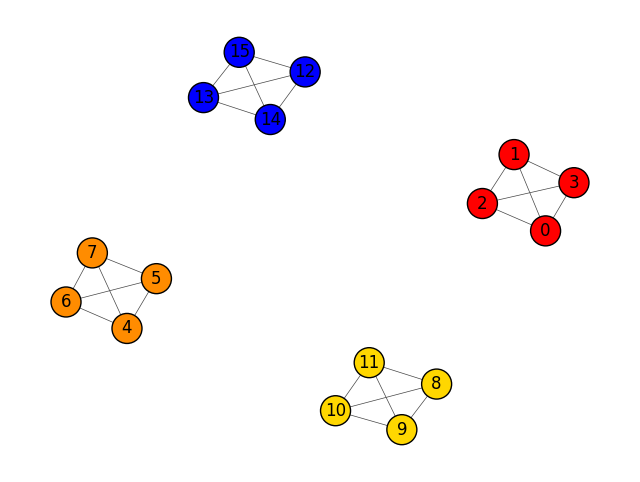

In [12]:
part_disc = spec_clust(A_disc,m=4)
print(part_disc)
#Número de nodos
n_disc = len(A_disc)
edgelist = trans_ady_sim(A_disc)
g = ig.Graph(edges = edgelist, directed = False)
g.es['width'] = 0.5
g.es["label_size"] = 8
fig,ax = subplots(figsize = (8,6))
list_v_colors = list_vertex_color(part_disc, n_disc)
ig.plot(g, vertex_size = 30, target = ax, edge_width = g.es['width'], vertex_label = range(n_disc), vertex_color = list_v_colors)

Grafo con 4 grupos de nodos conectados pero bien definidos

La conectividad algebraica de este grafo es:
0.35424868893541
La modularidad algebraica de este grafo es:
3.3014964765214456



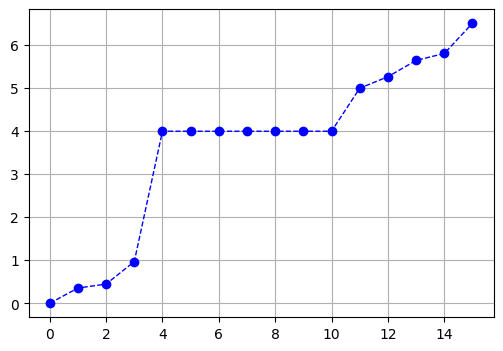

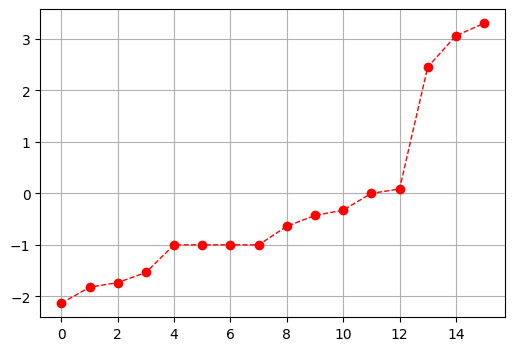

In [13]:
A_groups = array([[0,1,1,1,0,0,0,0,0,0,0,0,1,0,1,0],
                  [1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0],
                  [1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
                  [1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0],
                  [0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0],
                  [0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0],
                  [0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1],
                  [0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0],
                  [0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0],
                  [0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0],
                  [1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1],
                  [0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1],
                  [1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1],
                  [0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0]])

conec_alg_A_groups = connect_alg(A_groups,plotting=True)
print("La conectividad algebraica de este grafo es:")
print(conec_alg_A_groups)

mod_alg_A_groups = mod_alg(A_groups,plotting=True)
print("La modularidad algebraica de este grafo es:")
print(mod_alg_A_groups)
print()

Aplicar clustering espectral

[[4, 5, 6, 7], [12, 13, 14, 15], [8, 9, 10, 11], [0, 1, 2, 3]]


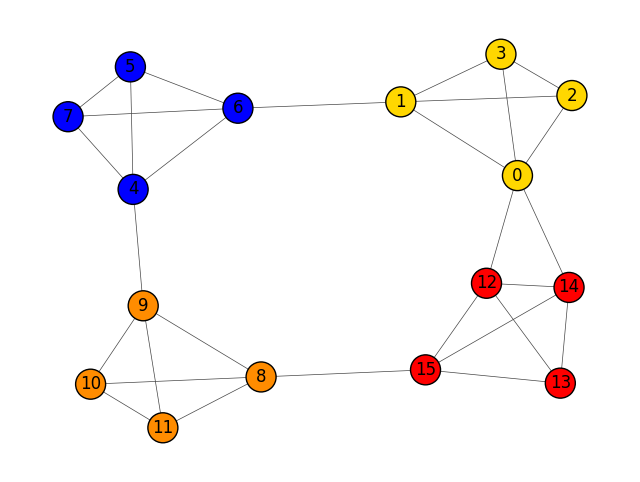

In [14]:
part_groups = spec_clust(A_disc,m=4)
print(part_groups)
#Número de nodos
n_groups = len(A_groups)
edgelist = trans_ady_sim(A_groups)
g = ig.Graph(edges = edgelist, directed = False)
g.es['width'] = 0.5
g.es["label_size"] = 8
fig,ax = subplots(figsize = (8,6))
list_v_colors = list_vertex_color(part_groups, n_groups)
ig.plot(g, vertex_size = 30, target = ax, edge_width = g.es['width'], vertex_label = range(n_groups), vertex_color = list_v_colors)

Grafo completo $K_{16}$

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


La conectividad algebraica de este grafo es:
(15.999999999999996+0j)
La modularidad algebraica de este grafo es:
(-1.5265566588595902e-16+0j)



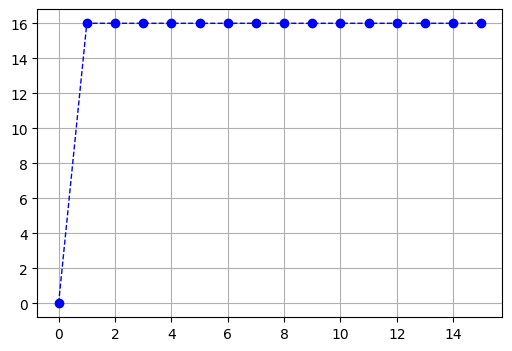

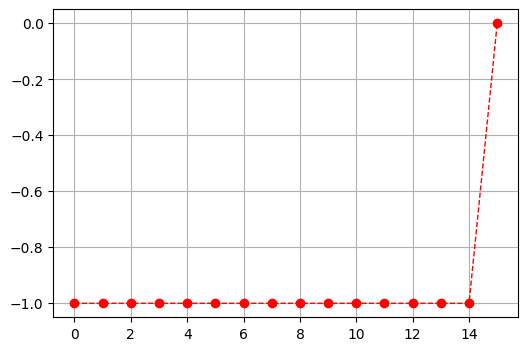

In [15]:
A_comp = array([[0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                [1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                [1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1],
                [1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1],
                [1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1],
                [1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1],
                [1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1],
                [1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1],
                [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]])

conec_alg_A_comp = connect_alg(A_comp,plotting=True)
print("La conectividad algebraica de este grafo es:")
print(conec_alg_A_comp)

mod_alg_A_comp = mod_alg(A_comp,plotting=True)
print("La modularidad algebraica de este grafo es:")
print(mod_alg_A_comp)
print()

No es posible particionar este grafo

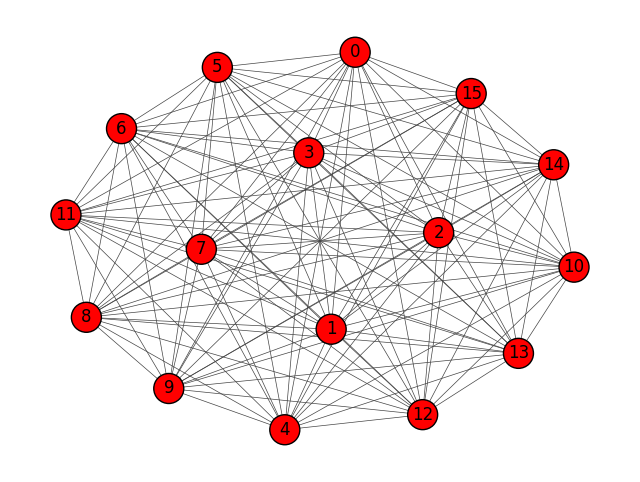

In [16]:
#Número de nodos
n_comp = len(A_comp)
edgelist = trans_ady_sim(A_comp)
g = ig.Graph(edges = edgelist, directed = False)
g.es['width'] = 0.5
g.es["label_size"] = 8
fig,ax = subplots(figsize = (8,6))
ig.plot(g, vertex_size = 30, target = ax, edge_width = g.es['width'], vertex_label = range(n_comp))

#Ejemplos con grafos ponderados

Grafo disconexo con cuatro componentes

La conectividad algebraica de este grafo es:
-1.1595322968324268e-15
La modularidad algebraica de este grafo es:
11.238092884290129



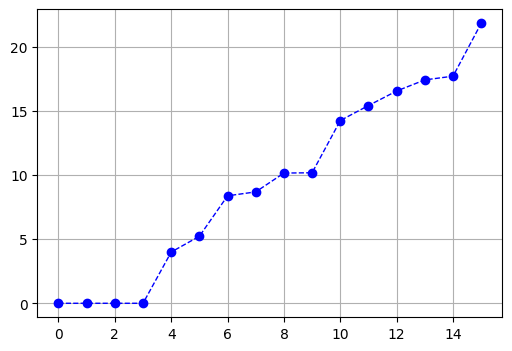

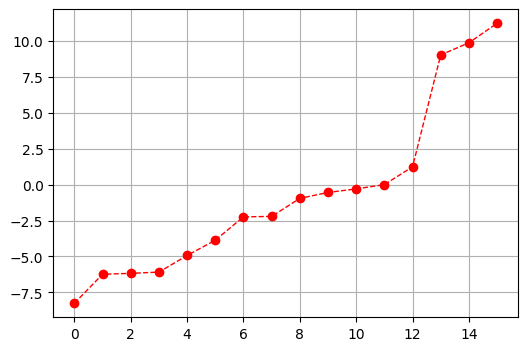

In [17]:
W_disc = array([[0,2,4,2,0,0,0,0,0,0,0,0,0,0,0,0],
                [2,0,5,1,0,0,0,0,0,0,0,0,0,0,0,0],
                [4,5,0,4,0,0,0,0,0,0,0,0,0,0,0,0],
                [2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,5,5,1,0,0,0,0,0,0,0,0],
                [0,0,0,0,5,0,4,1,0,0,0,0,0,0,0,0],
                [0,0,0,0,5,4,0,7,0,0,0,0,0,0,0,0],
                [0,0,0,0,1,1,7,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,2,3,6,0,0,0,0],
                [0,0,0,0,0,0,0,0,2,0,1,1,0,0,0,0],
                [0,0,0,0,0,0,0,0,3,1,0,3,0,0,0,0],
                [0,0,0,0,0,0,0,0,6,1,3,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,4,5,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,4,0,6,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0]])

conec_alg_W_disc = connect_alg(W_disc,plotting=True)
print("La conectividad algebraica de este grafo es:")
print(conec_alg_W_disc)

mod_alg_W_disc = mod_alg(W_disc,plotting=True)
print("La modularidad algebraica de este grafo es:")
print(mod_alg_W_disc)
print()

Aplicar clustering espectral

In [18]:
part_disc = spec_clust(W_disc,m=4)
print(part_disc)

[[8, 9, 10, 11], [4, 5, 6, 7], [12, 13, 14, 15], [0, 1, 2, 3]]


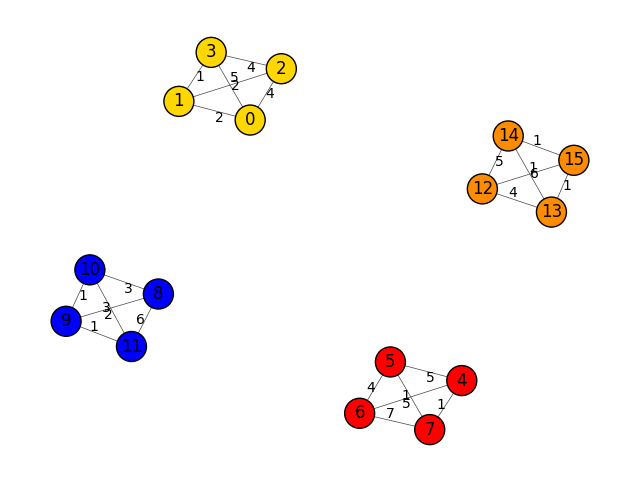

In [19]:
#Número de nodos
n_disc = len(W_disc)
edgelist = trans_ady_sim(W_disc)
g = ig.Graph(edges = edgelist, directed = False)
g.es['width'] = 0.5
g.es["label_size"] = 10
#Lista de pesos
W_list1 = W_list(edgelist, W_disc)
g.es['weight'] = W_list1
fig,ax = subplots(figsize = (8,6))
list_v_colors = list_vertex_color(part_disc, n_disc)
ig.plot(g, vertex_size = 30, target = ax, edge_width = g.es['width'], edge_label = g.es["weight"],vertex_label = range(n_disc), vertex_color = list_v_colors)

Grafo con cuatro grupos de nodos bien conectados

La conectividad algebraica de este grafo es:
0.6098077251113272
La modularidad algebraica de este grafo es:
12.05912911403877



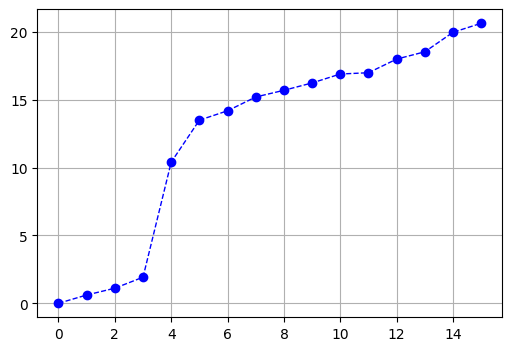

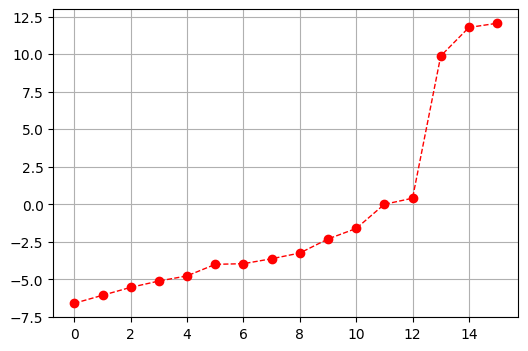

In [20]:
W_groups = array([[0,3,4,4,0,0,0,0,0,0,0,0,1,0,2,0],
                  [3,0,5,5,0,0,2,0,0,0,0,0,0,0,0,0],
                  [4,5,0,4,0,0,0,0,0,0,0,0,0,0,0,0],
                  [4,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,3,3,4,0,3,0,0,0,0,0,0],
                  [0,0,0,0,3,0,4,4,0,0,0,0,0,0,0,0],
                  [0,2,0,0,3,4,0,5,0,0,0,0,0,0,0,0],
                  [0,0,0,0,4,4,5,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,3,3,4,0,0,0,1],
                  [0,0,0,0,3,0,0,0,3,0,2,2,0,0,0,0],
                  [0,0,0,0,0,0,0,0,3,2,0,5,0,0,0,0],
                  [0,0,0,0,0,0,0,0,4,2,5,0,0,0,0,0],
                  [1,0,0,0,0,0,0,0,0,0,0,0,0,5,4,5],
                  [0,0,0,0,0,0,0,0,0,0,0,0,5,0,3,3],
                  [2,0,0,0,0,0,0,0,0,0,0,0,4,3,0,4],
                  [0,0,0,0,0,0,0,0,1,0,0,0,5,3,4,0]])

conec_alg_W_groups = connect_alg(W_groups,plotting=True)
print("La conectividad algebraica de este grafo es:")
print(conec_alg_W_groups)

mod_alg_W_groups = mod_alg(W_groups,plotting=True)
print("La modularidad algebraica de este grafo es:")
print(mod_alg_W_groups)
print()

Aplicar clustering espectral

In [21]:
part_groups = spec_clust(W_groups,m=4)
print(part_groups)

[[4, 5, 6, 7], [12, 13, 14, 15], [8, 9, 10, 11], [0, 1, 2, 3]]


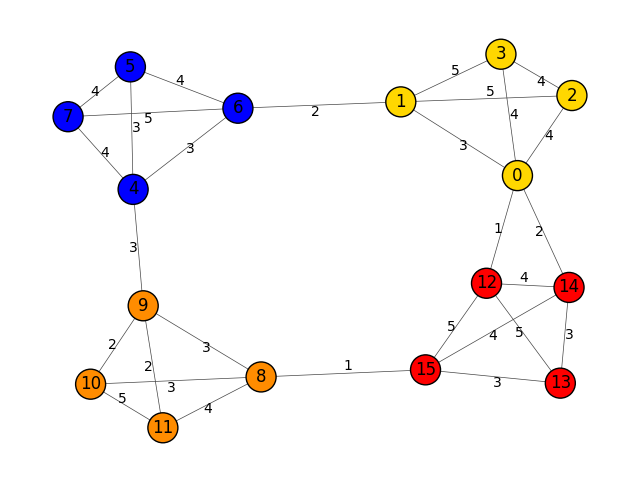

In [22]:
#Número de nodos
n_groups = len(W_groups)
edgelist = trans_ady_sim(W_groups)
g = ig.Graph(edges = edgelist, directed = False)
g.es['width'] = 0.5
g.es["label_size"] = 10
#Lista de pesos
W_list1 = W_list(edgelist, W_groups)
g.es['weight'] = W_list1
fig,ax = subplots(figsize = (8,6))
list_v_colors = list_vertex_color(part_groups, n_groups)
ig.plot(g, vertex_size = 30, target = ax, edge_width = g.es['width'], edge_label = g.es["weight"], vertex_label = range(n_groups), vertex_color = list_v_colors)

Grafo completo con grupos de nodos que poseen pesos altos

La conectividad algebraica de este grafo es:
16.135628426210225
La modularidad algebraica de este grafo es:
8.17193138557283



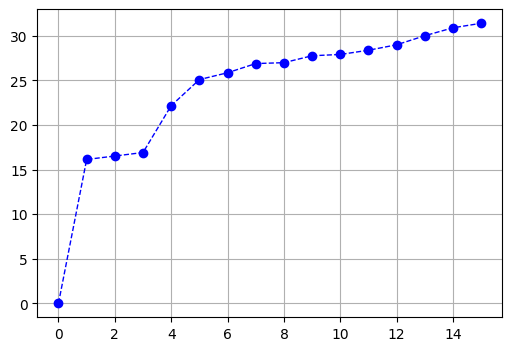

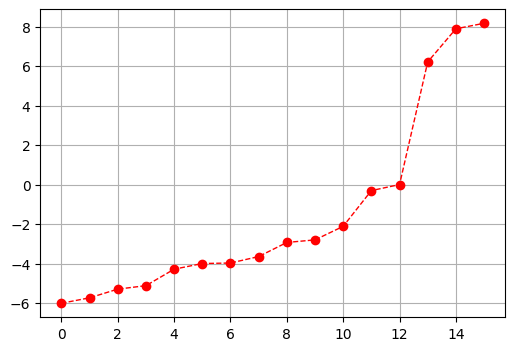

In [23]:
W_comp = array([[0,3,4,4,1,1,1,1,1,1,1,1,1,1,2,1],
                [3,0,5,5,1,1,2,1,1,1,1,1,1,1,1,1],
                [4,5,0,4,1,1,1,1,1,1,1,1,1,1,1,1],
                [4,5,4,0,1,1,1,1,1,1,1,1,1,1,1,1],
                [1,1,1,1,0,3,3,4,1,3,1,1,1,1,1,1],
                [1,1,1,1,3,0,4,4,1,1,1,1,1,1,1,1],
                [1,2,1,1,3,4,0,5,1,1,1,1,1,1,1,1],
                [1,1,1,1,4,4,5,0,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,0,3,3,4,1,1,1,1],
                [1,1,1,1,3,1,1,1,3,0,2,2,1,1,1,1],
                [1,1,1,1,1,1,1,1,3,2,0,5,1,1,1,1],
                [1,1,1,1,1,1,1,1,4,2,5,0,1,1,1,1],
                [1,1,1,1,1,1,1,1,1,1,1,1,0,5,4,5],
                [1,1,1,1,1,1,1,1,1,1,1,1,5,0,3,3],
                [2,1,1,1,1,1,1,1,1,1,1,1,4,3,0,4],
                [1,1,1,1,1,1,1,1,1,1,1,1,5,3,4,0]])

conec_alg_W_comp = connect_alg(W_comp,plotting=True)
print("La conectividad algebraica de este grafo es:")
print(conec_alg_W_comp)

mod_alg_W_comp = mod_alg(W_comp,plotting=True)
print("La modularidad algebraica de este grafo es:")
print(mod_alg_W_comp)
print()

Aplicar clustering espectral

In [24]:
part_comp = spec_clust(W_comp,m=4)
print(part_comp)

[[0, 1, 2, 3], [8, 9, 10, 11], [12, 13, 14, 15], [4, 5, 6, 7]]


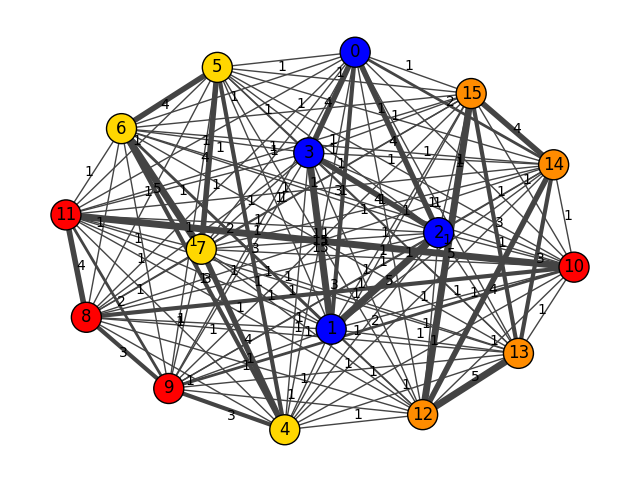

In [25]:
#Número de nodos
n_comp = len(W_comp)
edgelist = trans_ady_sim(W_comp)
g = ig.Graph(edges = edgelist, directed = False)
g.es['width'] = 0.5
g.es["label_size"] = 10
#Lista de pesos
W_list1 = W_list(edgelist, W_comp)
g.es['weight'] = W_list1
fig,ax = subplots(figsize = (8,6))
list_v_colors = list_vertex_color(part_comp, n_comp)
ig.plot(g, vertex_size = 30, target = ax, edge_width = W_list1, edge_label = g.es["weight"], vertex_label = range(n_comp), vertex_color = list_v_colors)

#Red de Star Wars Episodio III

Importar datos de la red ponderada en formato json

In [81]:
with open('/content/drive/MyDrive/DATOS_REDES/starwars-episode-3-interactions.json','r') as j:
    data_SW = json.load(j)

In [82]:
#Datos de los nodos
data_SW_nodes = data_SW['nodes']
#Número de nodos
n_SW = len(data_SW_nodes)
#Extraer etiquetas de los nodos
labels_nodes = []
for i in range(0,n_SW):
    node_act = data_SW_nodes[i]
    labels_nodes.append(node_act['name'])
print(labels_nodes)

['ANAKIN', 'OBI-WAN', 'ODD BALL', 'GENERAL GRIEVOUS', 'EMPEROR', 'COUNT DOOKU', 'BAIL ORGANA', 'C-3PO', 'PADME', 'YODA', 'FANG ZAR', 'MON MOTHMA', 'GIDDEAN DANU', 'MACE WINDU', 'CAPTAIN TYPHO', 'CLONE COMMANDER GREE', 'CLONE COMMANDER CODY', 'JAR JAR', 'TION MEDON', 'NUTE GUNRAY', 'PLO KOON', 'CAPTAIN ANTILLES', 'DARTH VADER', 'QUI-GON']


In [83]:
#Datos de las aristas
data_SW_edges = data_SW['links']
#Crear lista de adyacencias y pesos
#Número de nodos
n_edges_SW = len(data_SW_edges)
#Generar lista de aristas
edges_SW = []
#Generar lista de pesos
list_W_SW = []
for i in range(0,n_edges_SW):
    edge_act = data_SW_edges[i]
    edges_SW.append([edge_act['source'],edge_act['target']])
    list_W_SW.append(edge_act['value'])
#Generar matriz de pesos
W_SW = construct_W(edges_SW,list_W_SW,n_SW)

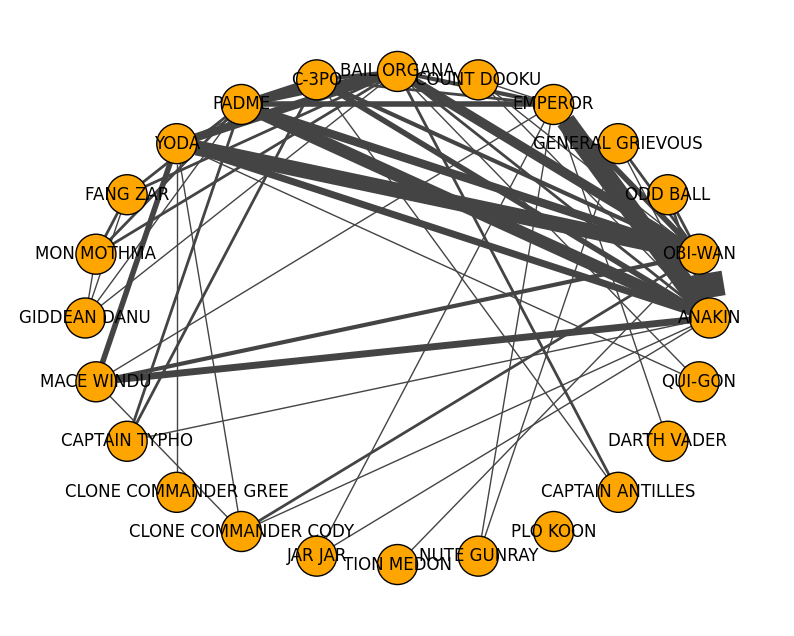

In [84]:
g = ig.Graph(edges = edges_SW, directed = False)
g.es['width'] = 0.5
g.es["label_size"] = 10
g.es['weight'] = list_W_SW
fig,ax = subplots(figsize = (10,8))
layout = g.layout("circle")
ig.plot(g, layout=layout, vertex_size = 40, target = ax, edge_width = list_W_SW, vertex_label = labels_nodes, vertex_size_label=4, vertex_color='orange')

Aplicar GeNA

In [85]:
u_eigs,part_SW = GeNA(W_SW)
#Obtener nivel de pertenencia
level_SW = level_membership_GeNA(u_eigs)
imp_names(part_SW,labels_nodes)
print(modularity(W_SW,part_SW))

Comunidad 0
['NUTE GUNRAY']
Comunidad 1
['BAIL ORGANA', 'C-3PO', 'PADME', 'FANG ZAR', 'MON MOTHMA', 'GIDDEAN DANU', 'CAPTAIN TYPHO', 'CAPTAIN ANTILLES', 'QUI-GON']
Comunidad 2
['ANAKIN', 'EMPEROR', 'COUNT DOOKU', 'JAR JAR', 'DARTH VADER']
Comunidad 3
['OBI-WAN', 'ODD BALL', 'GENERAL GRIEVOUS', 'YODA', 'MACE WINDU', 'CLONE COMMANDER GREE', 'CLONE COMMANDER CODY', 'TION MEDON']
0.1222337535484265


<ipython-input-8-a85c0b32e4c9>:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sum_com[k] = dot(dot(vec_ind_k.T,B),vec_ind_k)[0]


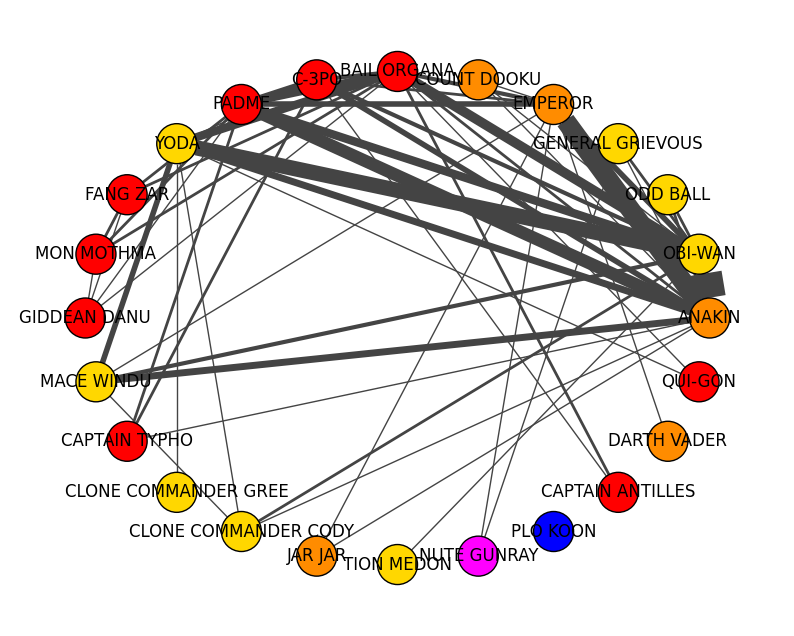

In [86]:
#Número de nodos
n_comp = len(W_SW)
edgelist = trans_ady_sim(W_SW)
g = ig.Graph(edges = edgelist, directed = False)
g.es['width'] = 0.5
g.es["label_size"] = 10
#Lista de pesos
W_list1 = W_list(edgelist, W_SW)
g.es['weight'] = W_list1
fig,ax = subplots(figsize = (10,8))
list_v_colors = list_vertex_color(part_SW+[[19]], n_SW)
layout = g.layout("circle")
ig.plot(g, layout=layout, vertex_size = 40, target = ax, edge_width = W_list1, vertex_label = labels_nodes, vertex_color = list_v_colors)

Nivel de pertenencia

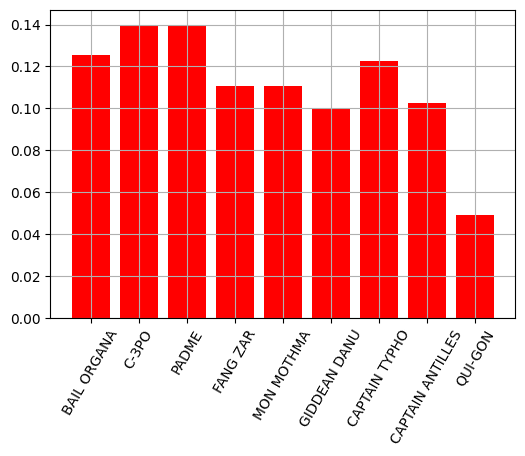

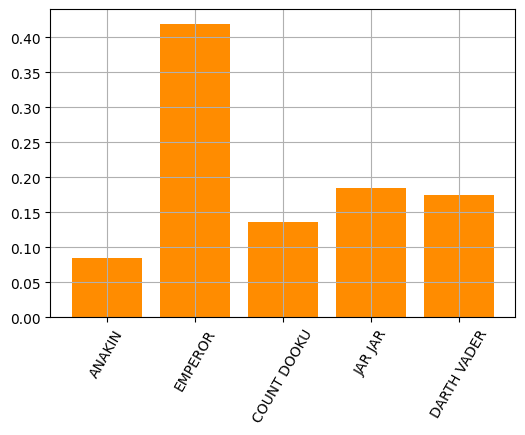

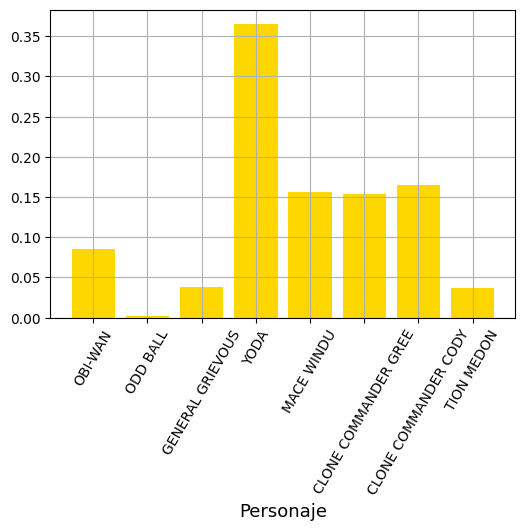

In [87]:
#Separar etiquetas por cada comunidad
lab_com = sep_labels(labels_nodes,part_SW)
#Histograma de nivel de pertenencia por cada comunidad
fig = figure(figsize = (6,4))
grid()
#xlabel("Number of state", fontsize=12)
bar(lab_com[1],level_SW[1], color = list_colors[1])
xticks(fontsize = 10)
tick_params(axis='x', rotation=60)
fig = figure(figsize = (6,4))
grid()
#xlabel("Number of state", fontsize=12)
bar(lab_com[2],level_SW[2], color = list_colors[2])
xticks(fontsize = 10)
tick_params(axis='x', rotation=60)
fig = figure(figsize = (6,4))
grid()
xlabel("Personaje", fontsize=13)
bar(lab_com[3],level_SW[3], color = list_colors[3])
xticks(fontsize = 10)
tick_params(axis='x', rotation=60)

Calcular centralidad laplaciana

In [88]:
#Create list of weighted edges using W
def create_list_W(W):
    #Size of matrix W
    n = len(W)
    #Inicialize list of weighted edges
    list_weighted_edges = []
    for i in range(0,n):
        for j in range(i+1,n):
              if W[i,j]>0:
                  list_weighted_edges.append((i,j,W[i,j]))
    return list_weighted_edges

#Create Networkx weighted graph based on W
def create_graph_W_nx(W):
    G = nx.Graph()
    list_weighted_edges = create_list_W(W)
    G.add_weighted_edges_from(list_weighted_edges)
    return G

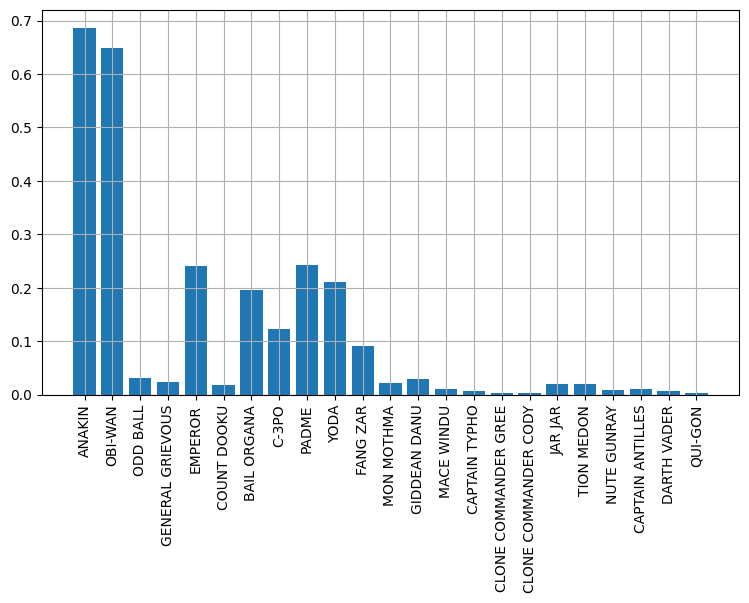

In [102]:
#Creación del grafo asociado a la matriz W_SW
G_nx_SW = create_graph_W_nx(W_SW)
lap_cent_SW = nx.laplacian_centrality(G_nx_SW).values()
#Separar etiquetas por cada comunidad
#Histograma de nivel de pertenencia por cada comunidad
fig = figure(figsize = (9,5))
grid()
#xlabel("Number of state", fontsize=12)
new_labels = labels_nodes.copy()
new_labels.remove('PLO KOON')
bar(new_labels,lap_cent_SW)
xticks(fontsize = 10)
tick_params(axis='x', rotation=90)

#Funciones implementadas para el manejo de mapas

In [105]:
def transf(com):
    #Etiquetas de los municipios que maneja el archivos shp del INEGI
    new_etiq=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,
              124,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123]
    n_com=len(com)
    new_com=[]
    for i in range(0,n_com):
        new_com.append([])
        com_act=com[i]
        n_act=len(com_act)
        new_com_act=new_com[i]
        for j in range(0,n_act):
            new_com_act.append(new_etiq[com_act[j]])
    return new_com

def transf_order_jal(com_lab):
    #Etiquetas de los municipios que maneja el archivos shp del INEGI
    new_etiq=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,
              124,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123]
    n_mun=len(new_etiq)
    new_com=zeros((n_mun))
    for i in range(0,n_mun):
           new_com[new_etiq[i]]=com_lab[i]
    return new_com

#Cambiar las listas de comunidades por una sola lista con el número de grupo de cada estado
def com_to_group(com):
    n_com=len(com)
    #Se va a sumar un vector de unos para detectar aquellos nodos que no fueron asignados a ninguna comunidad
    groups=zeros((125))+100*ones((125))
    for i in range(0,n_com):
        com_act=com[i]
        n_act=len(com[i])
        for j in range(0,n_act):
            groups[com_act[j]]=i
    groups_out=groups.tolist()
    return groups_out

#Cambiar etiquetas de grupos por nombres de los colores correspondientes
def change(groups,colors):
    n=len(groups)
    colors_out=[]
    for i in range(0,n):
        ind_group=int(groups[i])
        if ind_group!=100:
           colors_out.append(colors[ind_group])
        else:
        #Se colorea de blanco porque no fue asignado a ninguna comunidad
            colors_out.append("gainsboro")
    return colors_out

def generar_patches(colores):
    lista_patches=[]
    n_colors=len(colores)
    for i in range(0,n_colors):
        patch_act=mpatches.Patch(color=colores[i],label=str(i))
        lista_patches.append(patch_act)
    return lista_patches

def col_map_nivel(nivel,com):
    mun_nivel=zeros((125))
    n_com=len(com)
    for i in range(0,n_com):
        mun_nivel[com[i]]=nivel[i]
    return mun_nivel

def change_etiq_ord(group,list_com_ord):
    #Número de comunidades
    m=len(list_com_ord)
    #Número de municipios
    n=len(group)
    new_group=zeros((n))
    for i in range(0,n):
        #Comunidad que se debe buscar en  la lista
        com_list=int(group[i])
        #Posición de la comunidad en la lista
        ind_new=list_com_ord.index(com_list)
        new_group[i]=m-ind_new-1
    return new_group

#Importar datos para crear mapas

In [ ]:
mun_jal_map=geopandas.read_file(r'/content/drive/MyDrive/TESIS_DOCTORADO/LimiteMunicipal_MGJ2012_modificadoDecreto26837.shp')

In [ ]:
mun_jal_map.head()

#Generar matriz de pesos a partir de matriz de distancias vía carretera

In [ ]:
#Importar matriz de distancias
df1 = pd.read_excel("/content/drive/MyDrive/DATOS_REDES/Distancias2011_cabeceras.xlsx",sheet_name="Hoja7")
mat_dist0 = df1.values
mat_dist = (mat_dist0[:,1:126]+mat_dist0[:,1:126].T)/2
name_mun = df1['Unnamed: 0']

Construir matriz de pesos

In [ ]:
W_carr0 = zeros((125,125))
for i in range(0,125):
    for j in range(i+1,125):
        W_carr0[i,j] = 1/(1+mat_dist[i,j])
W_carr = W_carr0+W_carr0.T

Aplicar GeNA

In [ ]:
u_eigs_carr,part_carr = GeNA(W_carr)
#Obtener nivel de pertenencia
level_carr = level_membership_GeNA(u_eigs)
imp_names(part_carr,name_mun)
print(modularity(W_carr,part_carr))

In [ ]:
part_carr_new = transf(part_carr)
groups_carr = com_to_group(part_carr_new)
colors_carr = change(groups_carr,list_colors[0:len(part_carr)])
#Colorear mapa
fig,ax = subplots(figsize=(12,8))
#Asignar etiquetas de comunidades a colores
color_patches = generar_patches(list_colors[0:len(part_carr)])
ax.legend(handles = color_patches, loc=4)
ax.set_title('Partición de Jalisco de acuerdo a conectividad carretera', fontdict={'fontsize': '15', 'fontweight': '3'})
ax.axis('off')
mun_jal_map.plot(color=colors_carr,ax=ax)

Calcular nivel de pertenencia

In [ ]:
level_carr = level_membership_GeNA(u_eigs_carr)

In [ ]:
niv0_orig = col_map_nivel(level_carr[0],part_carr[0])
niv0_mod = transf_order_jal(niv0_orig)
mun_jal_map['Niv0'] = niv0_mod
#Set the range for the choropleth
titulo = 'Nivel de pertenencia la comunidad 0'
col = 'Niv0'
vmin = mun_jal_map[col].min()
vmax = mun_jal_map[col].max()
cmap = 'Blues'
#Create figure and axes for Matplotlib
fig,ax = subplots(1,figsize = (12,8))
#Remove the axis
ax.axis('off')
mun_jal_map.plot(column=col,ax=ax,edgecolor='0.1',linewidth=1,cmap=cmap)
#Add a title
ax.set_title(titulo, fontdict={'fontsize': '18', 'fontweight': '3'})
#Create colorbar as a legend
sm = cm.ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax),cmap=cmap)
#Empty array for the data range
sm._A = []
#Add the colorbar to the figure
cbaxes = fig.add_axes([0.22, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm,cax=cbaxes)
cbar.ax.tick_params(labelsize = 13)

In [ ]:
niv1_orig = col_map_nivel(level_carr[1],part_carr[1])
niv1_mod = transf_casos_jal(niv1_orig)
mun_jal_map['Niv1'] = niv1_mod
#Set the range for the choropleth
titulo = 'Nivel de pertenencia la comunidad 1'
col = 'Niv1'
vmin = mun_jal_map[col].min()
vmax = mun_jal_map[col].max()
cmap = 'Reds'
#Create figure and axes for Matplotlib
fig,ax = subplots(1,figsize = (12,8))
#Remove the axis
ax.axis('off')
mun_jal_map.plot(column=col,ax=ax,edgecolor='0.1',linewidth=1,cmap=cmap)
#Add a title
ax.set_title(titulo, fontdict={'fontsize': '18', 'fontweight': '3'})
#Create colorbar as a legend
sm = cm.ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax),cmap=cmap)
#Empty array for the data range
sm._A = []
#Add the colorbar to the figure
cbaxes = fig.add_axes([0.22, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm,cax=cbaxes)
cbar.ax.tick_params(labelsize = 13)

Calcular centralidad laplaciana

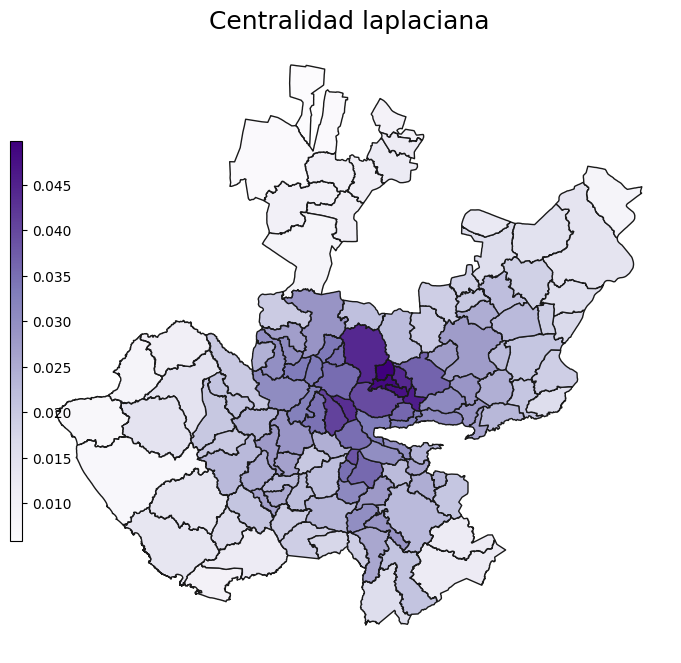

In [107]:
#Creacion del grafo asociado a la matriz de pesos W_carr
G_nx_carr = create_graph_W_nx(W_carr)
lap_cent_carr = nx.laplacian_centrality(G_nx_carr).values()

lap_cent_carr_new = transf_order_jal(list(lap_cent_carr))
mun_jal_map['Laplacian_cent_2'] = lap_cent_carr_new
#Set the range for the choropleth
titulo='Centralidad laplaciana'
col='Laplacian_cent_2'
vmin=mun_jal_map[col].min()
vmax=mun_jal_map[col].max()
cmap='Purples'
#Create figure and axes for Matplotlib
fig,ax=subplots(1,figsize=(12,8))
#Remove the axis
ax.axis('off')
mun_jal_map.plot(column=col,ax=ax,edgecolor='0.1',linewidth=1,cmap=cmap)
#Add a title
ax.set_title(titulo, fontdict={'fontsize': '18', 'fontweight': '3'})

#Create colorbar as a legend
sm=cm.ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax),cmap=cmap)
#Empty array for the data range
sm._A=[]
#Add the colorbar to the figure
cbaxes=fig.add_axes([0.23, 0.25, 0.01, 0.5])
cbar=fig.colorbar(sm,cax=cbaxes)